In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import logging
import argparse
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from itertools import product

/home/ubuntu/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Code

In [2]:
from tqdm import trange

In [3]:
import functions_hv_grad_3d

In [4]:
from functions_evaluation import compute_hv_in_higher_dimensions as compute_hv

In [5]:
import numpy as np
import torch

from functions_evaluation import fastNonDominatedSort
from functions_hv_grad_3d import grad_multi_sweep_with_duplicate_handling


class HvMaximization(object):
    """
    Mo optimizer for calculating dynamic weights using higamo style hv maximization
    based on Hao Wang et al.'s HIGA-MO
    uses non-dominated sorting to create multiple fronts, and maximize hypervolume of each
    """
    def __init__(self, n_mo_sol, n_mo_obj, ref_point, obj_space_normalize=True):
        super(HvMaximization, self).__init__()
        self.name = 'hv_maximization'
        self.ref_point = np.array(ref_point)
        self.n_mo_sol = n_mo_sol
        self.n_mo_obj = n_mo_obj
        self.obj_space_normalize = obj_space_normalize


    def compute_weights(self, mo_obj_val):
        n_mo_obj = self.n_mo_obj
        n_mo_sol = self.n_mo_sol

        # non-dom sorting to create multiple fronts
        hv_subfront_indices = fastNonDominatedSort(mo_obj_val)
        dyn_ref_point =  1.1 * np.max(mo_obj_val, axis=1)
        for i_obj in range(0,n_mo_obj):
            dyn_ref_point[i_obj] = np.maximum(self.ref_point[i_obj],dyn_ref_point[i_obj])
        number_of_fronts = np.max(hv_subfront_indices) + 1 # +1 because of 0 indexing
        
        obj_space_multifront_hv_gradient = np.zeros((n_mo_obj,n_mo_sol))
        for i_fronts in range(0,number_of_fronts):
            # compute HV gradients for current front
            temp_grad_array = grad_multi_sweep_with_duplicate_handling(mo_obj_val[:, (hv_subfront_indices == i_fronts) ],dyn_ref_point)
            obj_space_multifront_hv_gradient[:, (hv_subfront_indices == i_fronts) ] = temp_grad_array

        # normalize the hv_gradient in obj space (||dHV/dY|| == 1)
        normalized_obj_space_multifront_hv_gradient = np.zeros((n_mo_obj,n_mo_sol))
        for i_mo_sol in range(0,n_mo_sol):
            w = np.sqrt(np.sum(obj_space_multifront_hv_gradient[:,i_mo_sol]**2.0))
            if np.isclose(w,0):
                w = 1
            if self.obj_space_normalize:
                normalized_obj_space_multifront_hv_gradient[:,i_mo_sol] = obj_space_multifront_hv_gradient[:,i_mo_sol]/w
            else:
                normalized_obj_space_multifront_hv_gradient[:,i_mo_sol] = obj_space_multifront_hv_gradient[:,i_mo_sol]

        dynamic_weights = torch.tensor(normalized_obj_space_multifront_hv_gradient, dtype=torch.float)
        return(dynamic_weights)

In [6]:
def evenly_dist_weights(num_weights, dim):
    return [ret for ret in product(
        np.linspace(0.0, 1.0, num_weights), repeat=dim) if round(sum(ret), 3) == 1.0 and all(r not in (0.0, 1.0) for r in ret)]

In [7]:
class Toy_Hypernetwork(nn.Module):
  def __init__(self, ray_hidden_dim=30, out_dim=30, target_hidden_dim=15, n_hidden=1, n_tasks=2):
      super().__init__()
      self.n_hidden = n_hidden
      self.n_tasks = n_tasks

      self.ray_mlp = nn.Sequential(
            nn.Linear(2, ray_hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(ray_hidden_dim, ray_hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(ray_hidden_dim, ray_hidden_dim)
        )
      
      for j in range(n_tasks):
            setattr(self, f"task_{j}_weights", nn.Linear(ray_hidden_dim, out_dim))
            setattr(self, f"task_{j}_bias", nn.Linear(ray_hidden_dim, out_dim))

  def forward(self, ray):
      features = self.ray_mlp(ray)

      out_dict = {}
      layer_types = ["task"]
      for i in layer_types:
          if i == "hidden":
              n_layers = self.n_hidden
          elif i == "task":
              n_layers = self.n_tasks

          for j in range(n_layers):
              out_dict[f"{i}{j}.weights"] = getattr(self, f"{i}_{j}_weights")(features)
              out_dict[f"{i}{j}.bias"] = getattr(self, f"{i}_{j}_bias")(features).flatten()

      return out_dict

class Toy_Targetnetwork(nn.Module):
  def __init__(self, out_dim=30, target_hidden_dim=15, n_tasks=2):
      super().__init__()
      self.out_dim = out_dim
      self.n_tasks = n_tasks
      self.target_hidden_dim = target_hidden_dim

  def forward(self, weights=None):
    x = torch.ones([1, 1], dtype=torch.float32).to(device)
    outputs = []
    for j in range(self.n_tasks):
            outputs.append(
                F.linear(
                    x, weight=weights[f'task{j}.weights'].reshape(self.out_dim, x.shape[-1]),
                    bias=weights[f'task{j}.bias']
                )
            )
    return outputs

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
def toy_loss_1(output):
  return torch.mean(torch.cos(output[0, 0])**2) + 0.2

def toy_loss_2(output):
  return torch.mean(1.3+torch.sin(output[0, 1])**2-
                     torch.cos(output[0, 0])-0.1*torch.sin(22*torch.pi*torch.cos(output[0, 0])**2)**5) # -0.5

In [10]:
import random
def set_logger():
    logging.basicConfig(
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        level=logging.INFO
    )


def set_seed(seed):
    """for reproducibility
    :param seed:
    :return:
    """
    np.random.seed(seed)
    random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True



In [11]:
set_logger()

In [12]:
class parse_arg():
  def __init__(self):
    pass
args = parse_arg()
args.no_cuda = False
args.gpus = '2'

In [13]:
def get_device(no_cuda=False, gpus='0'):
    return torch.device(f"cuda:{gpus}" if torch.cuda.is_available() and not no_cuda else "cpu")
device=get_device(no_cuda=args.no_cuda, gpus=args.gpus)
#device=get_device(no_cuda=True)

In [14]:
from functions_evaluation import fastNonDominatedSort

In [15]:
import copy
from functions_hv_python3 import HyperVolume

# Trainer

In [16]:
from functions_evaluation import compute_hv_in_higher_dimensions as compute_hv
def evaluate_hv(soluong, start, end, hnet, net, ref_point):
  #print('Evaluate')
  results = []

  loss1 = toy_loss_1
  loss2 = toy_loss_2
  angles = np.linspace(start, end, soluong, endpoint=True)
  x = np.cos(angles)
  y = np.sin(angles)
  rays = np.c_[x, y]
  min_penalty= 999
  for i in range(soluong):
    ray = rays[i]
    ray = torch.from_numpy(
                        ray.astype(np.float32).flatten()
                    ).to(device)

    weights = hnet(ray)
    output = net(weights)[0]
    l1 = loss1(output)
    l2 = loss2(output)
    loss_batch = torch.stack((l1, l2)).detach().cpu().numpy()
    loss_batch = np.array(loss_batch)
    #loss_mean = np.mean(loss_batch, axis=0)
    penalty = np.sum(rays[i].astype(np.float32).flatten()*loss_batch)/(np.sqrt(np.sum(loss_batch**2)))
    if penalty < min_penalty:
      min_penalty = penalty
    results.append(loss_batch)
      
  results = np.array(results, dtype='float32')
  #print(results)
  return compute_hv(results.T, ref_point), results, min_penalty

In [17]:
def train(device: torch.device, hidden_dim:int, lr: float, wd: float, epochs:int, alpha:float, head:int, 
          hesophat:float,cfg):
  training = []
  partition = np.array([1/head]*head)
  hnet: nn.Module = Toy_Hypernetwork(ray_hidden_dim=hidden_dim, n_tasks=1)
  best_hv = 0
  net_list = []
  for i in range(head):
    net: nn.Module = Toy_Targetnetwork(n_tasks=1)
    net_list.append(net)
  logging.info(f"HN size: {count_parameters(hnet)}")

  hnet = hnet.to(device)
  for net in net_list:
    net = net.to(device)

  loss1 = toy_loss_1
  loss2 = toy_loss_2

  optimizer = torch.optim.Adam(hnet.parameters(), lr=lr, weight_decay=wd)

  ref_point = cfg["ref_point"]
  n_mo_sol = cfg["n_mo_sol"]
  n_mo_obj = cfg["n_mo_obj"]

  start = 0.
  end = np.pi/2
  print("Start Phase 1")
  phase1_iter = trange(150)

  optimizer_direction = torch.optim.Adam(hnet.parameters(), lr=5e-4, weight_decay=wd)
  for _ in phase1_iter:
    optimizer_direction.zero_grad()
    if (_+1) % 50 == 0:
      for param_group in optimizer.param_groups:
          param_group['lr'] *= np.sqrt(0.5)

      lr *= np.sqrt(0.5)    
    penalty_epoch = []

    losses_mean= []
    weights = []
    outputs = []
    rays = []
    penalty = []
    sum_penalty = 0
    for j in range(n_mo_sol):
      random = np.random.uniform(start, end)
      # random = np.random.uniform(start + j*(end-start)/head, start+ (j+1)*(end-start)/head)

      ray = np.array([np.cos(random),
                        np.sin(random)], dtype='float32')
                  
      rays.append(torch.from_numpy(
                      ray.flatten()
                  ).to(device))

      weights.append(hnet(rays[j]))
      outputs.append(net_list[j](weights[j])[0])
      losses_mean.append(torch.stack([loss1(outputs[j]), loss2(outputs[j])]))

      penalty.append(torch.sum(losses_mean[j]*rays[j])/(torch.norm(rays[j])*torch.norm(losses_mean[j])))

      sum_penalty += penalty[j].item()

    direction_loss = 0.
    for phat in penalty[:]:
        direction_loss -= phat
    direction_loss.backward()
    optimizer_direction.step()

    aaa = sum_penalty/float(head)
    phase1_iter.set_description(f"Epochs {_} penalty {aaa:.2f}")

  print("End phase 1 after {}".format(_))
  mo_opt = HvMaximization(n_mo_sol, n_mo_obj, ref_point)
  
  dem = 0
  epoch_iter = trange(epochs)
  for epoch in epoch_iter:
    dem += 1

    hnet.train()
    optimizer.zero_grad()

    loss_torch_per_sample = []
    loss_numpy_per_sample = []
    loss_per_sample = []
    weights = []
    outputs = []
    rays = []
    penalty = []
    for i in range(n_mo_sol):
      random = np.random.uniform(start, end)

      ray = np.array([np.cos(random),
                        np.sin(random)], dtype='float32')

      rays.append(torch.from_numpy(
                      ray.flatten()
                  ).to(device))
      weights.append(hnet(rays[i]))

      outputs.append(net_list[i](weights[i])[0])
      
      loss_per_sample = torch.stack([loss1(outputs[i]), loss2(outputs[i])])

      loss_torch_per_sample.append(loss_per_sample)
      loss_numpy_per_sample.append(loss_per_sample.cpu().detach().numpy())

      penalty.append(torch.sum(loss_torch_per_sample[i]*rays[i])/
                     (torch.norm(loss_torch_per_sample[i])*torch.norm(rays[i])))

    loss_numpy_per_sample = np.array(loss_numpy_per_sample)[np.newaxis, :, :].transpose(0, 2, 1) #n_samples, obj, sol

    n_samples = 1
    dynamic_weights_per_sample = torch.ones(n_mo_sol, n_mo_obj, n_samples)
    for i_sample in range(0, n_samples):
      weights_task = mo_opt.compute_weights(loss_numpy_per_sample[i_sample,:,:])
      dynamic_weights_per_sample[:, :, i_sample] = weights_task.permute(1,0)
      
    dynamic_weights_per_sample = dynamic_weights_per_sample.to(device)
    i_mo_sol = 0
    total_dynamic_loss = torch.mean(torch.sum(dynamic_weights_per_sample[i_mo_sol, :, :]
                                              * loss_torch_per_sample[i_mo_sol], dim=0))
    for i_mo_sol in range(1, len(net_list)):
      total_dynamic_loss += torch.mean(torch.sum(dynamic_weights_per_sample[i_mo_sol, :, :] 
                                          * loss_torch_per_sample[i_mo_sol], dim=0))
    
    for idx in range(head):
      total_dynamic_loss -= hesophat*penalty[idx]*partition[idx]
    
      
    total_dynamic_loss /= head
    total_dynamic_loss.backward()
    optimizer.step()

    penalty = [i.item() for i in penalty]

    if epoch % 300 ==0:
      training.append([i.detach().cpu().tolist() for i in loss_torch_per_sample])
  return hnet, net, training, partition

# Test

In [18]:
cfg = {}
cfg["ref_point"] = (2, 2)
cfg["n_mo_obj"] = 2
cfg["n_mo_sol"] = 16
device = get_device(no_cuda=args.no_cuda, gpus=args.gpus)
hidden_dim=100
lr=1e-3
wd=0.
epochs=10000.
alpha=0.2
cfg= cfg
head=cfg["n_mo_sol"]
hesophat=300. # this is lambda
n_mo_obj = cfg["n_mo_obj"]
n_mo_sol = cfg["n_mo_sol"]
ref_point = cfg["ref_point"]
method = "3_MH_"

In [19]:
hnet, net, training, partition = train(device = device, hidden_dim=100,
                  lr=1e-3, wd=0., epochs=10000, alpha=0.2, cfg= cfg, head=cfg['n_mo_sol'], hesophat=hesophat)

2022-12-15 19:19:47,013 - root - INFO - HN size: 26560


Start Phase 1


Epochs 149 penalty 0.96: 100%|██████████| 150/150 [00:08<00:00, 18.30it/s]


End phase 1 after 149


100%|██████████| 10000/10000 [09:22<00:00, 17.78it/s]


In [20]:
results = []
loss1 = toy_loss_1
loss2 = toy_loss_2
soluong = 1000

start = 0.
end = np.pi/2
random_lst = np.linspace(start, end, soluong)

for i in range(soluong):
  random = random_lst[i]
  ray = np.array([np.cos(random),
                      np.sin(random)], dtype='float32')
                               
  ray = torch.from_numpy(
                      ray.flatten()
                  ).to(device)

  weights = hnet(ray)
  output = net(weights)[0]
  l1 = loss1(output)
  l2 = loss2(output)
  results.append([l1, l2])

In [21]:
results = [[i[0].cpu().detach().numpy(), i[1].cpu().detach().numpy()] for i in results]
results = np.array(results, dtype='float32')

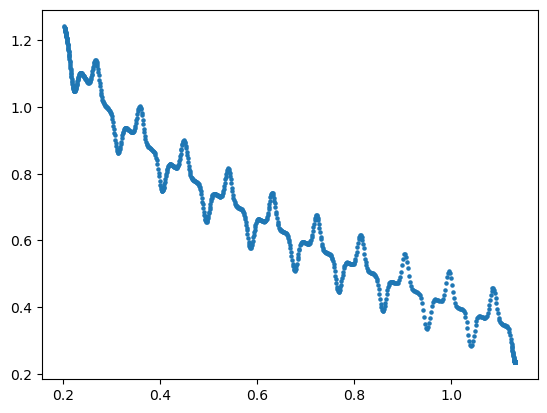

In [22]:
plt.scatter(results[:, 0], results[:, 1], s=5)

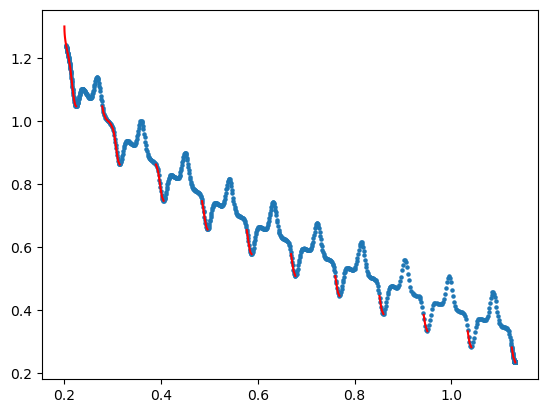

In [23]:
plt.scatter(results[:, 0], results[:, 1], s=5)
z = np.load("front/toy3_truth.npy")
plt.plot(z[:, 0], z[:, 1], color='red')


In [24]:
# np.save("front/Toy_"+method+".pt", results)